### Import section

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from skimage import color
from skimage.feature import hog

In [2]:
import warnings
import itertools
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# !pip install visualkeras
import tensorflow as tf
import visualkeras
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# # General parameters
# np.random.seed(42)
# tf.random.set_seed(42)

In [5]:
# pip install opencv-python
import cv2
import os

folder_path = "s_dataset"             # base/root directory

no_tumor = os.listdir(folder_path + '/no_tumor/')
glioma = os.listdir(folder_path + '/glioma/')
meningioma = os.listdir(folder_path + '/meningioma/')
pituitary = os.listdir(folder_path + '/pituitary/')
craniopharyngioma = os.listdir(folder_path + '/craniopharyngioma_final_1070/')

# no_tumor, glioma, meningioma, pituitary, craniopharyngioma

dataset=[]
lab=[]

In [6]:
for image_name in no_tumor:
    image=cv2.imread(folder_path + '/no_tumor/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)

In [7]:
for image_name in glioma:
    image=cv2.imread(folder_path + '/glioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [8]:
for image_name in meningioma:
    image=cv2.imread(folder_path + '/meningioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(2)

In [9]:
for image_name in pituitary:
    image=cv2.imread(folder_path + '/pituitary/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(3)

In [10]:
for image_name in craniopharyngioma:
    image=cv2.imread(folder_path + '/craniopharyngioma_final_1070/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(4)

In [11]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(8103, 240, 240, 3) (8103,)


### Deep Feature Extraction

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255)

subdirectories = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma_final_1070']

# Create a generator for the images in the subdirectories
generator = datagen.flow_from_directory(
    folder_path,
    target_size=(240,240),
    batch_size=32,
    class_mode='categorical',
#     class_mode=None,
    shuffle=False,
    classes=subdirectories)

Found 8103 images belonging to 5 classes.


In [13]:
# Input layer
from keras.layers import Concatenate, Input, Flatten, Dense

input_layer = Input(shape=(240, 240, 3))

In [15]:
# Concatenate the extracted features
concatenated_features = np.load('efe_features.npy')

In [16]:
print(len(concatenated_features))

8103


In [17]:
print(len(concatenated_features[1]))

149381


In [18]:
from tensorflow.keras.layers import Input

# Flatten the features to use them for classification
features_flatten = np.reshape(concatenated_features, (concatenated_features.shape[0], -1))

# Define the labels for the images in the subdirectories
labels = generator.classes

### SVM

In [36]:
from sklearn.svm import SVC

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features_flatten, labels, test_size=0.2, random_state=42)

# Initialize and train an SVC model
svc_model = SVC(kernel='linear', probability=True)
svc_model.fit(train_features, train_labels)

# Predict the labels of the testing set using the trained SVC model
predicted_labels = svc_model.predict(test_features)

# Generate a classification report and confusion matrix
report = classification_report(test_labels, predicted_labels, target_names=subdirectories)
matrix = confusion_matrix(test_labels, predicted_labels)

print(report)

                              precision    recall  f1-score   support

                    no_tumor       0.99      0.99      0.99       414
                      glioma       0.99      0.96      0.98       335
                  meningioma       0.94      0.98      0.96       339
                   pituitary       1.00      0.99      0.99       345
craniopharyngioma_final_1070       0.99      0.98      0.99       188

                    accuracy                           0.98      1621
                   macro avg       0.98      0.98      0.98      1621
                weighted avg       0.98      0.98      0.98      1621



In [37]:
print(matrix)

[[410   0   3   0   1]
 [  0 322  13   0   0]
 [  2   3 333   1   0]
 [  1   0   3 341   0]
 [  2   0   1   0 185]]


In [38]:
from sklearn.metrics import r2_score
r2_score(test_labels, predicted_labels)

0.9659643796499333

In [39]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(test_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'])

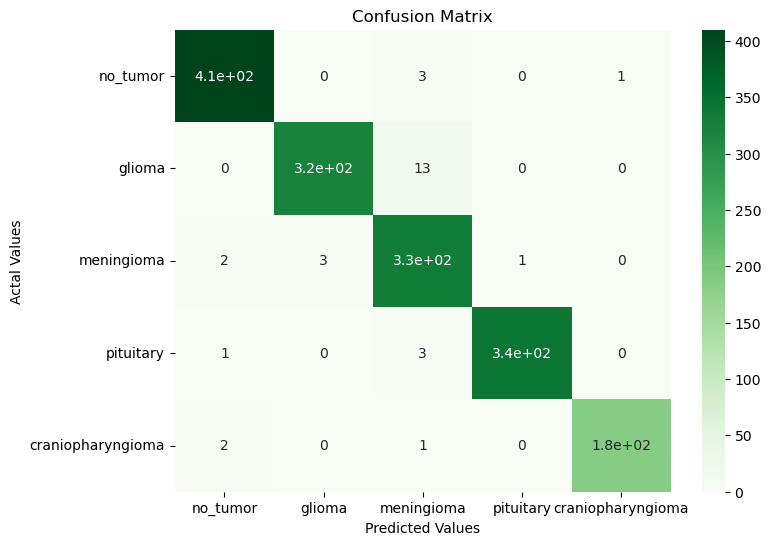

In [40]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [41]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_labels,average='micro')

0.9814929056138186

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.9814929056138186

In [43]:
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_labels,average='micro')

0.9814929056138186

In [44]:
from sklearn.metrics import recall_score
recall_score(test_labels, predicted_labels,average='micro')

0.9814929056138186

In [45]:
test_labels.shape

(1621,)

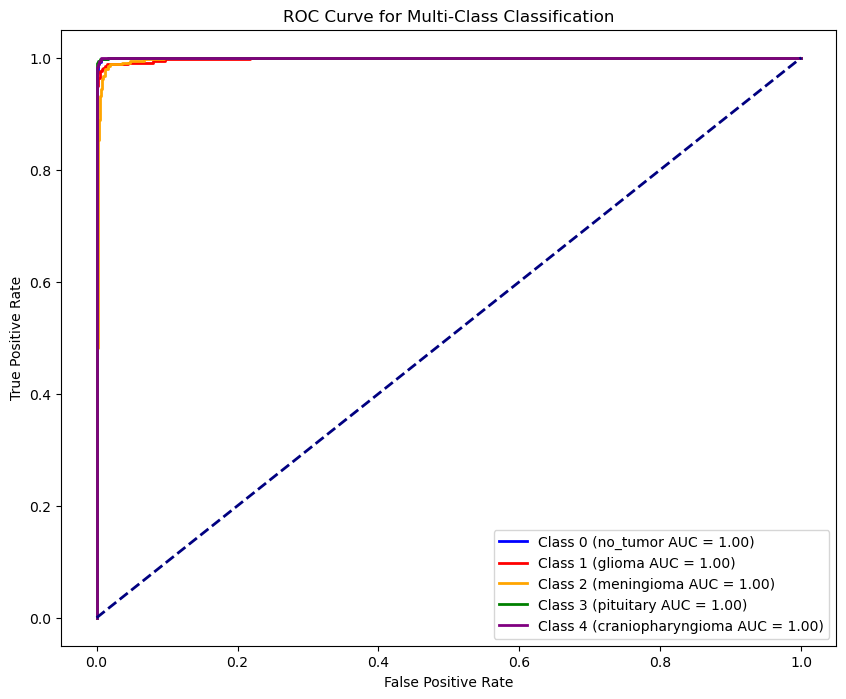

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

classes = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma']

y_true = test_labels


y_prob = svc_model.predict_proba(test_features)

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(5))

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()

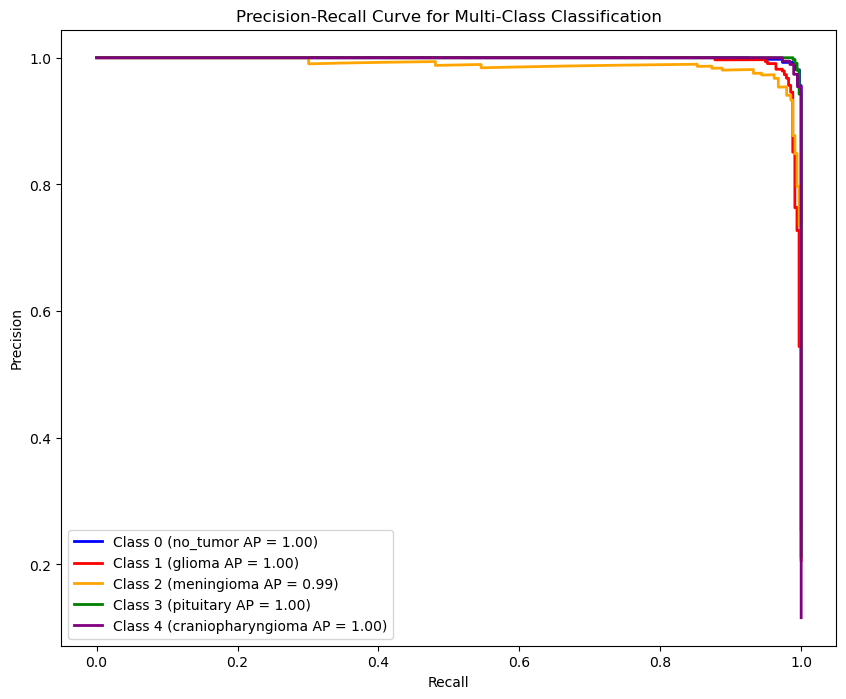

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize arrays for precision-recall curve
precision = dict()
recall = dict()
average_precision = dict()


for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the precision-recall curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend()
plt.show()

[[410   0   3   0   1]
 [  0 322  13   0   0]
 [  2   3 333   1   0]
 [  1   0   3 341   0]
 [  2   0   1   0 185]]


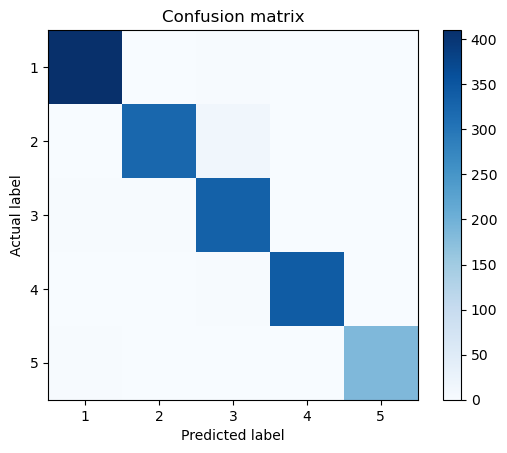

In [49]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Find the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix as a heatmap
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(5), np.arange(1, 6))
plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion matrix')
plt.show()

In [50]:
# Import numpy library
import numpy as np

cm = matrix

# Get the number of classes
n_classes = cm.shape[0]

# Initialize an empty list to store the specificity values
specificity = []

# Loop over each class
for i in range(n_classes):
  # Calculate the true negatives and false positives for class i
  tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i])
  fp = np.sum(cm[:, i]) - cm[i, i]

  # Calculate the specificity for class i
  spec = tn / (tn + fp)

  # Append the specificity to the list
  specificity.append(spec)

# Print the specificity values
print("Specificity for each class:")
for i in range(n_classes):
  print(f"Class {i}: {specificity[i]:.2f}")

Specificity for each class:
Class 0: 0.99
Class 1: 1.00
Class 2: 0.98
Class 3: 1.00
Class 4: 1.00


In [51]:
# Import numpy library
import numpy as np

# Calculate the false positives, false negatives, true positives, and true negatives for each class
fp = np.sum(cm, axis=0) - np.diag(cm)
fn = np.sum(cm, axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = np.sum(cm) - (fp + fn + tp)

# Calculate the false positive rate, false negative rate, true positive rate, and true negative rate for each class
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# Print the FPR, FNR, TPR, and TNR values for each class
print("FPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fpr[i]:.2f}")

print("FNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fnr[i]:.2f}")

print("TPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tpr[i]:.2f}")

print("TNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tnr[i]:.2f}")

FPR for each class:
Class 0: 0.00
Class 1: 0.00
Class 2: 0.02
Class 3: 0.00
Class 4: 0.00
FNR for each class:
Class 0: 0.01
Class 1: 0.04
Class 2: 0.02
Class 3: 0.01
Class 4: 0.02
TPR for each class:
Class 0: 0.99
Class 1: 0.96
Class 2: 0.98
Class 3: 0.99
Class 4: 0.98
TNR for each class:
Class 0: 1.00
Class 1: 1.00
Class 2: 0.98
Class 3: 1.00
Class 4: 1.00


## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Rest of the code
train_features, test_features, train_labels, test_labels = train_test_split(
    features_flatten, labels, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_labels)

predicted_labels = rf_model.predict(test_features)

report = classification_report(test_labels, predicted_labels, target_names=subdirectories)
matrix = confusion_matrix(test_labels, predicted_labels)

print(report)

                              precision    recall  f1-score   support

                    no_tumor       0.97      0.96      0.97       414
                      glioma       0.97      0.87      0.92       335
                  meningioma       0.85      0.87      0.86       339
                   pituitary       0.88      0.98      0.92       345
craniopharyngioma_final_1070       1.00      0.96      0.98       188

                    accuracy                           0.93      1621
                   macro avg       0.93      0.93      0.93      1621
                weighted avg       0.93      0.93      0.93      1621



In [53]:
print(matrix)

[[397   1  11   5   0]
 [  1 292  36   6   0]
 [  6   4 295  34   0]
 [  2   3   3 337   0]
 [  2   0   2   3 181]]


In [54]:
from sklearn.metrics import r2_score
r2_score(test_labels, predicted_labels)

0.9026109477111954

In [55]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(test_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'])

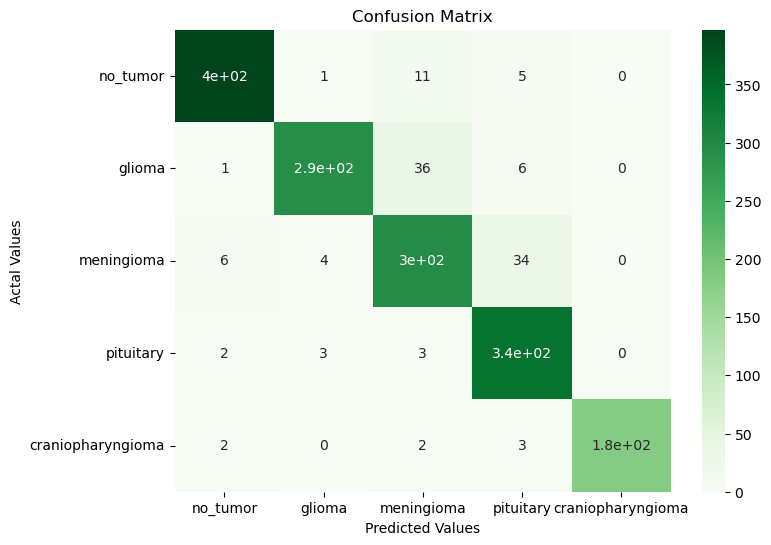

In [56]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [57]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_labels,average='micro')

0.9265885256014805

In [58]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.9265885256014805

In [59]:
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_labels,average='micro')

0.9265885256014804

In [60]:
from sklearn.metrics import recall_score
recall_score(test_labels, predicted_labels,average='micro')

0.9265885256014805

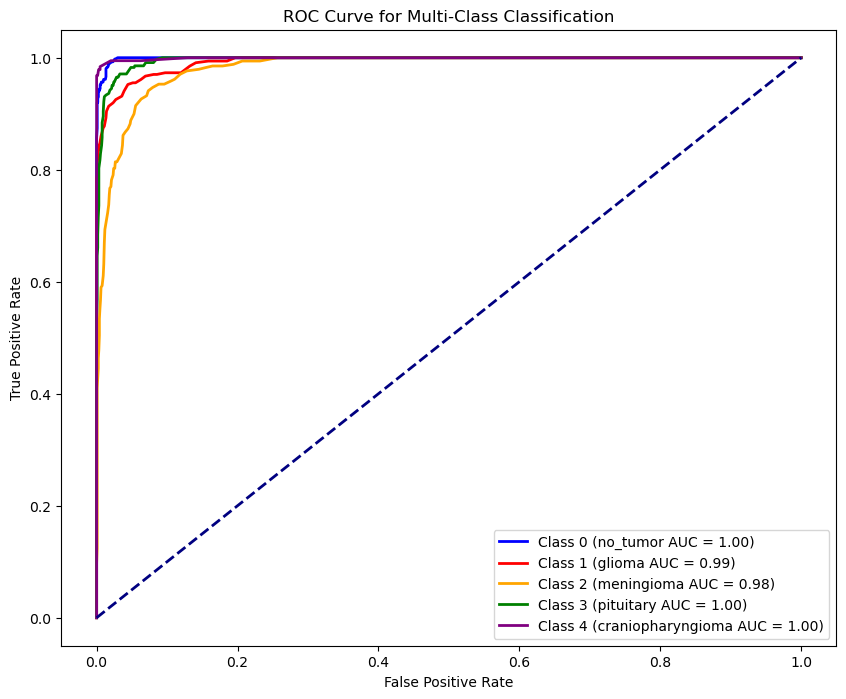

In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

classes = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma']

y_true = test_labels

y_prob = rf_model.predict_proba(test_features)

# Binarize the true labels
y_true_bin = label_binarize(test_labels, classes=np.arange(5))

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()

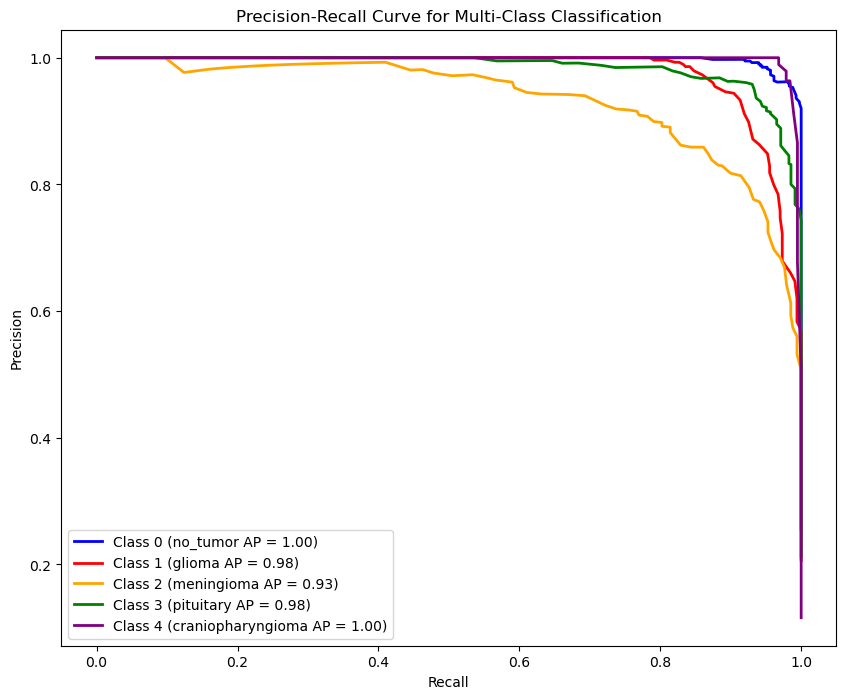

In [62]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize arrays for precision-recall curve
precision = dict()
recall = dict()
average_precision = dict()


for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the precision-recall curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend()
plt.show()

[[397   1  11   5   0]
 [  1 292  36   6   0]
 [  6   4 295  34   0]
 [  2   3   3 337   0]
 [  2   0   2   3 181]]


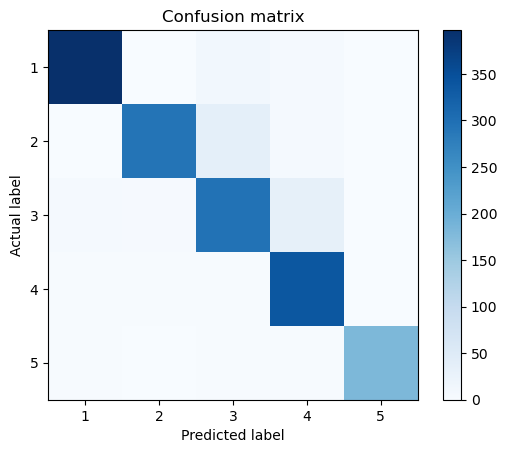

In [66]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Find the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix as a heatmap
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(5), np.arange(1, 6))
plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion matrix')
plt.show()

In [67]:
# Import numpy library
import numpy as np

cm = matrix

# Get the number of classes
n_classes = cm.shape[0]

# Initialize an empty list to store the specificity values
specificity = []

# Loop over each class
for i in range(n_classes):
  # Calculate the true negatives and false positives for class i
  tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i])
  fp = np.sum(cm[:, i]) - cm[i, i]

  # Calculate the specificity for class i
  spec = tn / (tn + fp)

  # Append the specificity to the list
  specificity.append(spec)

# Print the specificity values
print("Specificity for each class:")
for i in range(n_classes):
  print(f"Class {i}: {specificity[i]:.2f}")

Specificity for each class:
Class 0: 0.99
Class 1: 0.99
Class 2: 0.95
Class 3: 0.95
Class 4: 1.00


In [68]:
# Import numpy library
import numpy as np

# Calculate the false positives, false negatives, true positives, and true negatives for each class
fp = np.sum(cm, axis=0) - np.diag(cm)
fn = np.sum(cm, axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = np.sum(cm) - (fp + fn + tp)

# Calculate the false positive rate, false negative rate, true positive rate, and true negative rate for each class
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# Print the FPR, FNR, TPR, and TNR values for each class
print("FPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fpr[i]:.2f}")

print("FNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fnr[i]:.2f}")

print("TPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tpr[i]:.2f}")

print("TNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tnr[i]:.2f}")

FPR for each class:
Class 0: 0.01
Class 1: 0.01
Class 2: 0.04
Class 3: 0.04
Class 4: 0.00
FNR for each class:
Class 0: 0.04
Class 1: 0.13
Class 2: 0.13
Class 3: 0.02
Class 4: 0.04
TPR for each class:
Class 0: 0.96
Class 1: 0.87
Class 2: 0.87
Class 3: 0.98
Class 4: 0.96
TNR for each class:
Class 0: 0.99
Class 1: 0.99
Class 2: 0.96
Class 3: 0.96
Class 4: 1.00


## XGB

In [69]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()
print(xgbc)

xgbc.fit(train_features, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [70]:
# Predict the labels of the testing set using the trained model
predicted_labels = xgbc.predict(test_features)

# Generate a classification report and confusion matrix
report = classification_report(test_labels, predicted_labels, target_names=subdirectories)
matrix = confusion_matrix(test_labels, predicted_labels)

print(report)

                              precision    recall  f1-score   support

                    no_tumor       0.99      0.98      0.98       414
                      glioma       0.99      0.92      0.96       335
                  meningioma       0.90      0.93      0.92       339
                   pituitary       0.93      0.98      0.96       345
craniopharyngioma_final_1070       0.99      0.97      0.98       188

                    accuracy                           0.96      1621
                   macro avg       0.96      0.96      0.96      1621
                weighted avg       0.96      0.96      0.96      1621



In [71]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(test_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'])

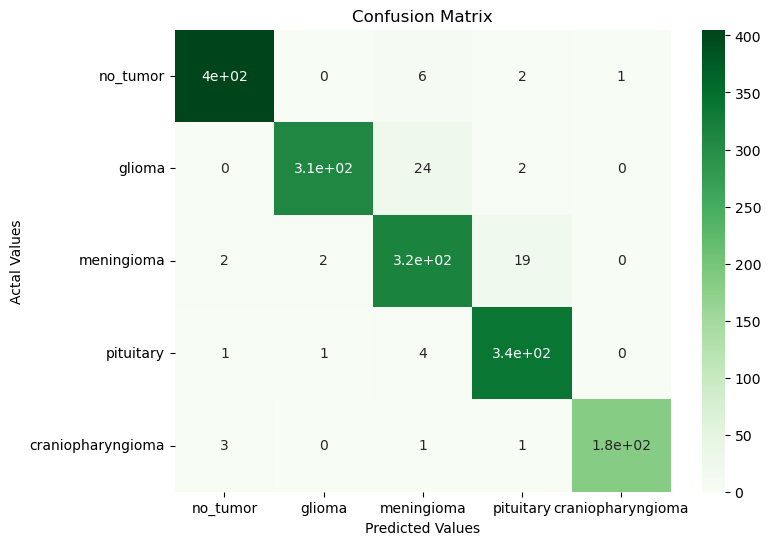

In [72]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [73]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.9574336829117829

In [74]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_labels,average='micro')

0.9574336829117829

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.9574336829117829

In [76]:
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_labels,average='micro')

0.9574336829117829

In [77]:
from sklearn.metrics import recall_score
recall_score(test_labels, predicted_labels,average='micro')

0.9574336829117829

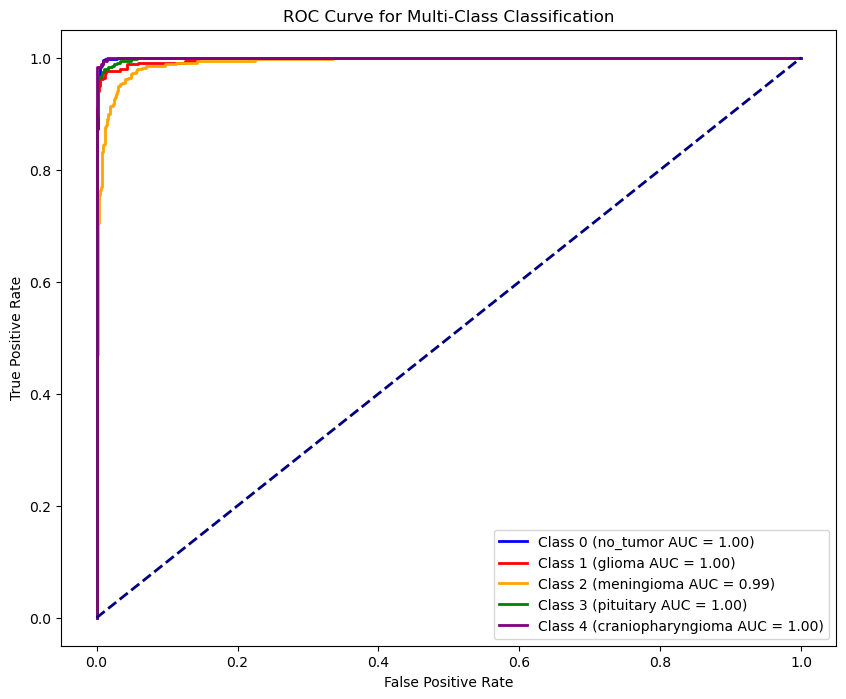

In [78]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

classes = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma']

y_true = test_labels

y_prob = xgbc.predict_proba(test_features)

# Binarize the true labels
y_true_bin = label_binarize(test_labels, classes=np.arange(5))

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()

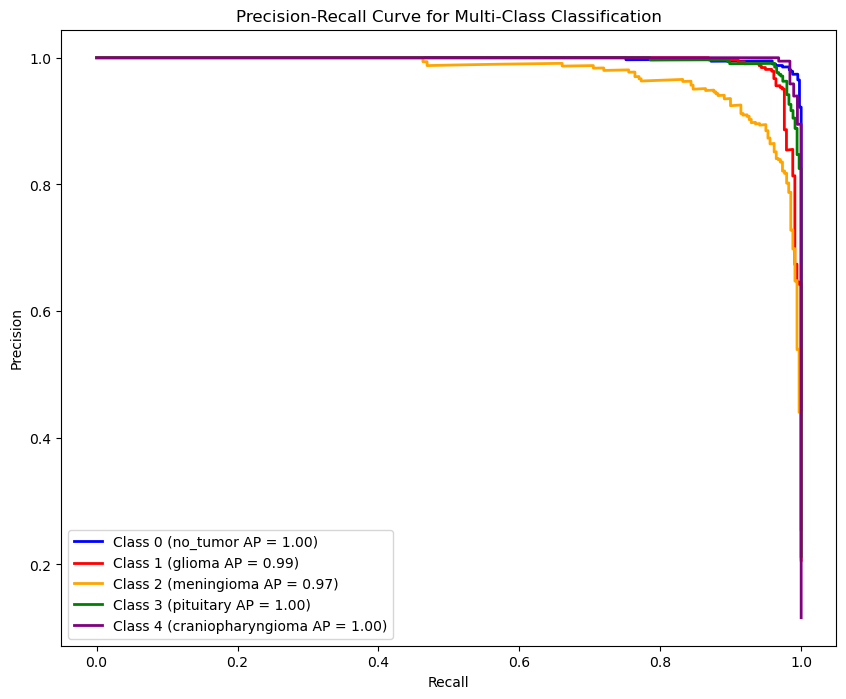

In [79]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize arrays for precision-recall curve
precision = dict()
recall = dict()
average_precision = dict()


for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the precision-recall curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend()
plt.show()

[[405   0   6   2   1]
 [  0 309  24   2   0]
 [  2   2 316  19   0]
 [  1   1   4 339   0]
 [  3   0   1   1 183]]


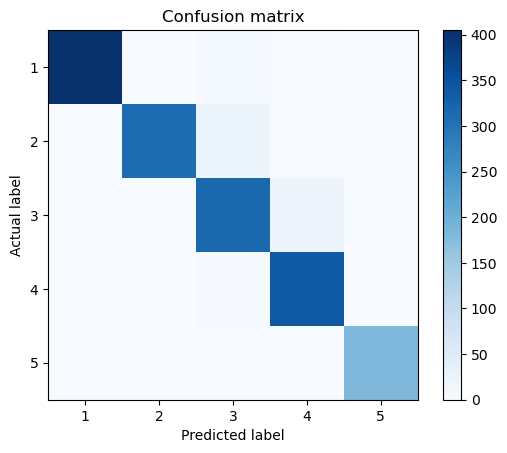

In [80]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Find the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix as a heatmap
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(5), np.arange(1, 6))
plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion matrix')
plt.show()

In [81]:
# Import numpy library
import numpy as np

cm = matrix

# Get the number of classes
n_classes = cm.shape[0]

# Initialize an empty list to store the specificity values
specificity = []

# Loop over each class
for i in range(n_classes):
  # Calculate the true negatives and false positives for class i
  tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i])
  fp = np.sum(cm[:, i]) - cm[i, i]

  # Calculate the specificity for class i
  spec = tn / (tn + fp)

  # Append the specificity to the list
  specificity.append(spec)

# Print the specificity values
print("Specificity for each class:")
for i in range(n_classes):
  print(f"Class {i}: {specificity[i]:.2f}")

Specificity for each class:
Class 0: 0.99
Class 1: 1.00
Class 2: 0.96
Class 3: 0.97
Class 4: 1.00


In [82]:
# Import numpy library
import numpy as np

# Calculate the false positives, false negatives, true positives, and true negatives for each class
fp = np.sum(cm, axis=0) - np.diag(cm)
fn = np.sum(cm, axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = np.sum(cm) - (fp + fn + tp)

# Calculate the false positive rate, false negative rate, true positive rate, and true negative rate for each class
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# Print the FPR, FNR, TPR, and TNR values for each class
print("FPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fpr[i]:.2f}")

print("FNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fnr[i]:.2f}")

print("TPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tpr[i]:.2f}")

print("TNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tnr[i]:.2f}")

FPR for each class:
Class 0: 0.00
Class 1: 0.00
Class 2: 0.03
Class 3: 0.02
Class 4: 0.00
FNR for each class:
Class 0: 0.02
Class 1: 0.08
Class 2: 0.07
Class 3: 0.02
Class 4: 0.03
TPR for each class:
Class 0: 0.98
Class 1: 0.92
Class 2: 0.93
Class 3: 0.98
Class 4: 0.97
TNR for each class:
Class 0: 1.00
Class 1: 1.00
Class 2: 0.97
Class 3: 0.98
Class 4: 1.00
